In [ ]:
%pip install -Uqq fastbook nbdev
from fastbook import *

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
path

In [ ]:
path.ls()

In [ ]:
(path/'train').ls()

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

In [ ]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

NumPy array:

In [ ]:
array(im3)

PyTorch tensor:

In [ ]:
tensor(im3)

In [ ]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

Tensors containing all of our 3s and 7s stacked together:

In [ ]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

In [ ]:
show_image(three_tensors[3001])

Compute the average over all the imnages of the intesity of each pixel with a rank-3 tensor:

In [ ]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

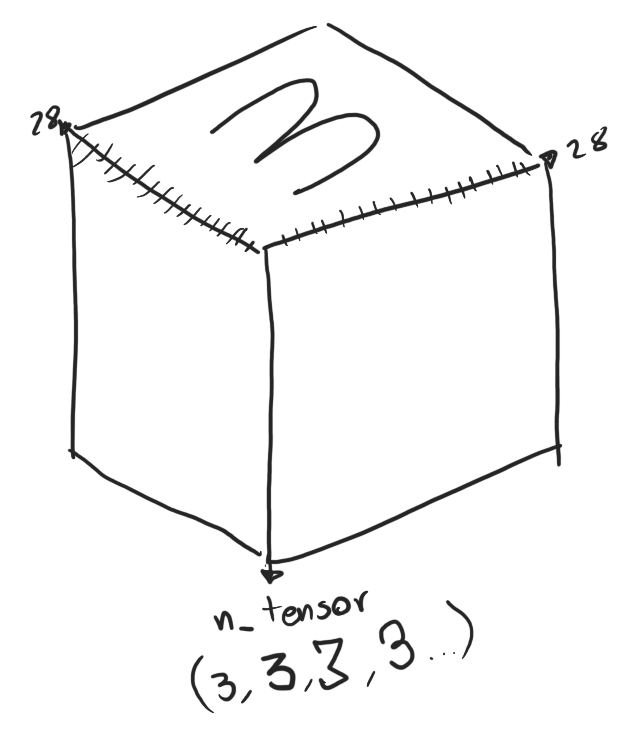

In [ ]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

In [ ]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

Sample 3 and 7 images:

In [ ]:
a_3 = stacked_threes[1]
a_7 = stacked_sevens[1]

Determine distance from our ideal 3 and 7:

Absolute value of differences / mean absolute difference / L1 norm:

In [ ]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_7_abs = (a_3 - mean7).abs().mean()
dist_3_abs,dist_7_abs

Mean of the square of the differences / root mean square error / L2 norm:

In [ ]:
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_3_sqr,dist_7_sqr

In [ ]:
from fastai.vision.all import *

In [ ]:
F.l1_loss(a_3.float(),mean7),F.mse_loss(a_3,mean7).sqrt()

Get the validation set:

In [ ]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape,valid_7_tens.shape

Write a function that calculates the mean absolute error:

In [ ]:
def mnist_distance(a, b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

Calculate a metric for overall accuracy using the distance to the ideal 3 for every image in the validation set:

In [ ]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

Because we have the substaction (a-b) in mnist_distance, PyTorch uses broadcasting to treat *mean3* (rank-2 tensor) as if it were a rank-3 tensor with its third dimension having size of 1010 (the number of 3s in the validation set). This is done by pretending the rank-2 has a third dimension. **IT DOESN'T ALLOCATE ANY ADDITIONAL MEMORY**.

Example of the previous explanation:

In [ ]:
tensor([[1,2,3], [4,5,6]]) + tensor([1,1,1])

The shapre of the result basic operation matches the bigger tensor (rank-3 tensor) shape:

In [ ]:
(valid_3_tens-mean3).shape

Define the fucntion is_3 that follows this logic: If the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it's a 3. Otherwise, it's a 7.

In [ ]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

Run a test:

In [ ]:
is_3(a_3), is_3(a_3).float()

In [ ]:
is_3(a_7), is_3(a_7).float()

It can also be tested with the validation set thanks to broadcasting:

In [ ]:
is_3(valid_3_tens)

Calculate the accuracy for each 3 and 7 by taking the average of that function for all 3s and the inverse for all 7s:

In [ ]:
accuracy_3s =      is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

Concatenate our independent variables (images) into a single tensor and change the rank of the tensor from 3 to 2:

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28) # -1 means "as many as needed to make this work"

Use a label for each image:

**1s are assigned to 3s and 0s to 7s**

1 = 3 \
0 = 7

In [ ]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

Datasets should return a touple of (x, y) when indexed. Python's zip function can do that. 

In [ ]:
dset = list(zip(train_x, train_x))
x, y = dset[0]
x.shape, y

In [ ]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

Use an initial weight (random at start) for every pixel:

In [ ]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28, 1))

The function weights*pixels won't be flexible enough. We need to initialize a random number too:

In [ ]:
bias = init_params(1)

The formula for a line is a reference. 

y = w*x+b

Where W is called weights and B bias. Toguether those two make up the parameters.

Calculate a prediction for one image:

In [ ]:
(train_x[0]*weights.T).sum() + bias

Don't use a loop to calculate the predictions for all the images. Use matrix multiplication instead.

Matrix multiplication is represented by the @ symbol in Python:

In [ ]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

To decide if the prediction is a 3 or a 7, we need to compare it to 0. The accuracu for each item can be calculated using broadcasting:

In [ ]:
corrects = (preds>0.0).float() == train_y
corrects

Apply a small change to the weights to see if the accuracy improves:

In [ ]:
# weights[0] *= 1.0001
# "RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation."
# Previous line from the book doesn't work, so I changed it to the following.
weights[0].data *= 1.0001

preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

Create a loss function.

It will have the arguments *trgts* (the target values) and *prds* (the predictions).

In this example, we suppose that we have three images that we know are 3, 7, and 3.

We suppose that our model predicted:
- The first image is a 3 with high confidence (0.9)
- The second image is a 7 with slight confidence (0.4)
- The third image is a 7, which is incorrect, with fair confidence (0.2)

In [ ]:
trgts = tensor([1,0,1])
prds = tensor([0.9, 0.4, 0.2])

First try of a loss function that measures the distance between the predictions and the targets:

In [ ]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

The function 
```python
    torch.where(a, b, c)
``` 

is the same as running the list comprehension 

```python
    [b[i] if a[i] else c[i] for i in range(len(a))]
```

except that it works on tensors and is much faster.

Test the ```where``` function with the predictions and the targets:

In [ ]:
torch.where(trgts==1, 1-prds, prds)

The previous function returnas a lower number when:
- Predictions are more accurate
- Accurate predictions are more confident 
- Incorrect predictions are less confident

In *PyTorch*, we always assume that a **lower value of a loss is better**.

---

```mnist_loss``` takes the mean of the previous tensor, since we need a scalar for the final loss:

In [ ]:
mnist_loss(prds,trgts)

Change our predictions of the "false" statement to see if the loss improves:

In [ ]:
mnist_loss(tensor([
    0.9, 
    0.4, 
    0.8 # was 0.2, predicting a 7 (assigned value 0) when it's a 3 (assigned value 1)
]),trgts)

The loss is lower, which is good and implies that the new predictions are better.

Problem!

```mnist_loss``` currently assumes that predictions are always between 0s and 1s. This is not the case. We need a function for that.

---

# Sigmoid

This function always outputs a number between 0 and 1. It's defined as follows:

```python
    def sigmoid(x): return 1/(1+torch.exp(-x))
```

This function is important for deep learning, since we often want to ensure values between 0 and 1.

In [ ]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

Update the loss function to apply ```sigmoid``` to the inputs:

In [ ]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

---

# Optimization step (SGD & mini-batches)

The loss function mnist_loss is suitable for SGD, so the optimization step is considered.

This optimization requires to calculate the loss over a single or multiple data items. The following points prevent us from doing that:
- Doing this calculation for the whole dataset takes too long and is computationally expensive. 
- The calculation for a single item doesn't provide enough information to make a good update.

Intead of compromising with one of the previous options, we can use a **mini-batch**. This calculates the average loss for a few data items at a time.

The number of data items in each mini-batch is called the **batch size**.

Bigger batch size = more accurate and stable estimate of the gradient = longer time to calculate.

## Data augmentation

Allows us to get better generalization by varying things (like the what data items we put in each mini-batch) during training.

We randomly shuffle the dataset on each epoch before creating mini-batches.

PyTorch and fastai provide a class that does this for us called ```DataLoader```.

In [ ]:
coll = range(15)
dl = DataLoader(
    coll, 
    batch_size=5,
    shuffle=True
)
# change batch_size and/or shuffle and see what happens
list(dl)

For model training is required to have a collection of independent and dependent variables.

PyTorch has a type of collections that contains tuples of independent and dependent variables called ```Dataset```.

In [ ]:
ds = L(enumerate(string.ascii_lowercase))
ds

---

# Putting all together

Time to implement the ***gradient descent process*** previously explained.

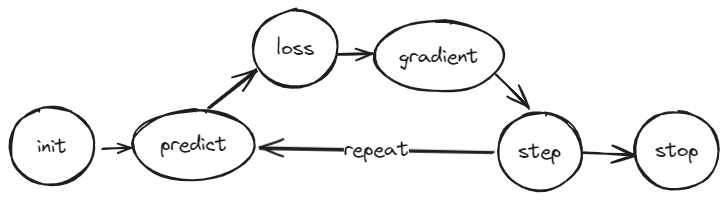

In code, the process should be implemented something like this for each epoch:

```python
    for x, y in dl:
        pred = model(x)
        loss = loss_func(pred, y)
        loss.backward()
        parameters -= parameters.grad * lr
```

Reinitialize parameters:

In [ ]:
weights = init_params((28*28,1))
bias = init_params(1)

Create a ```DataLoader``` from a ```Dataset```:

In [ ]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

Same thing for the validation set:

In [ ]:
valid_dl = DataLoader(valid_dset, batch_size=256)

Create a mini-batch of size 4 for testing:

In [ ]:
batch = train_x[:4]
batch.shape

In [ ]:
preds = linear1(batch)
preds

In [ ]:
loss = mnist_loss(preds, train_y[:4])
loss

Calculate gradients:

In [ ]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

Pull all in a function:

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

Test the function:

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

Something happens if the function is called twice:

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

The gradients change because ```loss.backward``` adds the gradients of ```loss``` to any gradients that are currently stored.

Set the current gradients to 0 first:

In [ ]:
weights.grad.zero_()
bias.grad.zero_()

Update the weights and biases based on the gradient and learning rate (and exclide the gradients from this step):


In [ ]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

We need to check how we're doing by calculating the accuracy of the validation set. 

To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0.

In [ ]:
(preds>0.0).float() == train_y[:4]

That gives us this function to calculate the validation accuracy:

In [ ]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

Check if it works:

In [ ]:
batch_accuracy(linear1(batch), train_y[:4])

Put the batches together:

In [ ]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

validate_epoch(linear1)

That's the entry point. Let's train for one epoch and see if the accuracy improves:

In [ ]:
lr = 1
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

Then do a few more:

In [ ]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

Next step is to create an object to handle the SGD step automatically.

In PyTorch this is called **optimizer**.

# Creating an Optimizer